c:\Users\ngcao\Documents\dev\uni\final_thesis\ScoreAGC\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

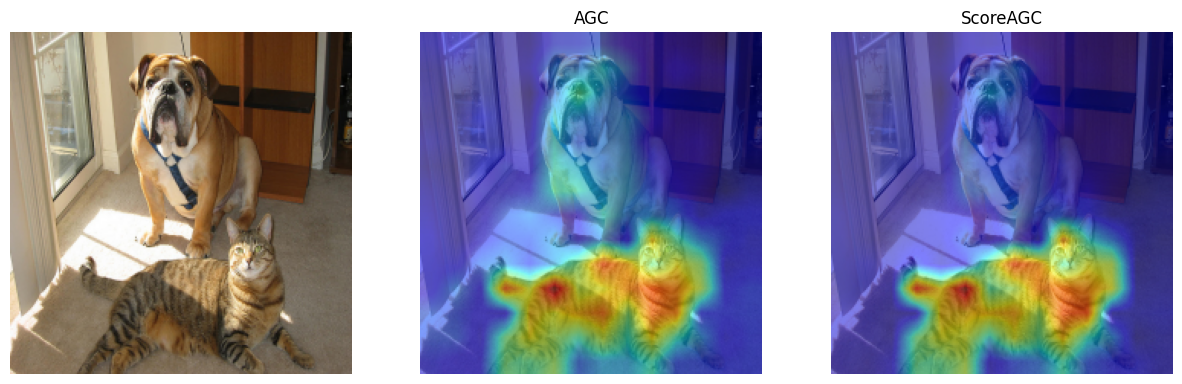

In [1]:
import Methods.AGCAM.ViT_for_AGCAM as ViT_Ours
from Methods.AGCAM.AGCAM import AGCAM
from Methods.ScoreAGC import ScoreAGC 

import torch 
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms

import numpy as np
import random
import PIL
import matplotlib.pyplot as plt

def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(777)

def create_vit_model(model_name, num_classes, state_dict, strict=True):
    model = ViT_Ours.create_model(model_name, pretrained=True, num_classes=num_classes).to('cuda')
    model.load_state_dict(state_dict if isinstance(state_dict, dict) else state_dict['model_state'], strict=strict)
    return model.eval()


# Image transformation
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# For convert the input image into original distribution to display
unnormalize = transforms.Compose([
    transforms.Normalize([0., 0., 0.], [1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize([-0.5, -0.5, -0.5], [1., 1., 1.,])
])

# Open the input image and transform
IMG_SIZE=224
IMAGE_PATH = "./samples/catdog.png"
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')


# Load the model parameters from Timm library
state_dict = model_zoo.load_url("https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth", progress=True, map_location='cuda')
model = create_vit_model("vit_base_patch16_224", 1000, state_dict)
method = ScoreAGC(model)
prediction, saliency_map = method(image)

heatmap = torch.nn.Upsample(224, mode='bilinear', align_corners=False)(saliency_map.reshape(1, 1, 14, 14))
heatmap = (heatmap - heatmap.min())/(heatmap.max()-heatmap.min())
heatmap = heatmap.detach().cpu().numpy()[0]
heatmap = np.transpose(heatmap, (1, 2, 0))

with torch.enable_grad():
    # Generate heatmap of our method
    agc_method = AGCAM(model)
    prediction, agc_heatmap = agc_method.generate(image)
    agc_heatmap = transforms.Resize((224, 224))(agc_heatmap[0])
    agc_heatmap = (agc_heatmap - agc_heatmap.min())/(agc_heatmap.max()-agc_heatmap.min())
    agc_heatmap = agc_heatmap.detach().cpu().numpy()
    agc_heatmap = np.transpose(agc_heatmap, (1, 2, 0))


# Display the results
image = unnormalize(image)
image = image.detach().cpu().numpy()[0]
image = np.transpose(image, (1, 2, 0))
fig, axs = plt.subplots(1,3, figsize=(15, 70))
axs[0].imshow(image)
axs[0].axis('off')

axs[1].set_title('AGC')
axs[1].imshow(image)
axs[1].imshow(agc_heatmap, cmap='jet', alpha=0.5)
axs[1].axis('off')

axs[2].set_title('ScoreAGC')
axs[2].imshow(image)
axs[2].imshow(heatmap, cmap='jet', alpha=0.5)
axs[2].axis('off')
